# FNIRS FINGERPRINT SIMILARITY

**Note:** Preprocessing code was written separately in part by my labmates Matt Russell and Maddie Brower. The preprocessing method that uses the Beer Lambert Law is as follows:

```
#
# This section does the initial preprocessing of the data files. It
# 1. creates a single csv file for each data type
# 2. ffills the block-level information (nback, movement, practice)
# 3. organizes column names
# 4. downsamples EEG data to 100Hz
# 5. marks data with correct nback level.
# 6. drops practice trials and any data outside of main experiment blocks
# 7. removes unnecessary column from eyetracking data
# 8. for fNIRS data, subtract averages of the preceding rest block t o produce relative changes (Delta Oxy/Deoxy).
#    [note the rest data for fNIRS is not removed for consistency, but has basically served its purpose]
#
#
# Problems:
# 1. We are just finding the largest xdf file for each participant if there are multiple. Obviously this is problematic.
#
# Random Note:
# 'Tx7' / 'Tx2' are short source-detector sensors.
#
import pandas as pd
import numpy as np
from scipy import signal
from pathlib import Path
from tqdm.notebook import tqdm
import pyxdf
from labels import *

all_data = {}
all_p = Path('data')
for p in tqdm(list(all_p.glob('sub-*'))):
    pid = p.name.split('-')[1]
    largest_file = max(p.glob('ses-*/**/*.xdf'), key=lambda f: f.stat().st_size)

    data, _ = pyxdf.load_xdf(largest_file)

    d_dict = {}
    for k in ['Nback', 'EEG-EEG', 'iViewNG-Gaze', 'OxySoft']: #'HeartRate' -- no heart rate data??

        #Currently the way this is written it just errors if there is one/some of the information streams is unavailable - with an index out of bounds error
        #TODO: we need to decide what info streams are necessary and should throw a better error
        #the list comprehension - grab all of the info streams that match whats in K in grab the first match and put it in the dictionary
        d_dict[k] = [x for x in data if x['info']['name'] == [k]][0]

    for k, v in d_dict.items():
        #time_series is the actual values - this is a fuck ass name that comes from lsl
        d = pd.DataFrame(v['time_series'])
        match k:
            case 'iViewNG-Gaze' | 'OxySoft':
                d.columns = [x['label'][0] for x in v['info']['desc'][0]['channels'][0]['channel']]
            case 'EEG-EEG':
                d.columns = [x['name'][0] for x in v['info']['desc'][0]['channel']]
            case 'Nback':
                d.columns = ['marker']
                d['marker'] = d['marker'].apply(lambda x: marker_lookups[x])


        d['time'] = v['time_stamps']
        # so at this point want we have is ['Nback', 'EEG-EEG', 'iViewNG-Gaze', 'OxySoft'] as keys in the dictionary
        #the value is a data frame with corresponding data and a time stamp
        d_dict[k] = d

        # downsample EEG data to 100Hz
        if k == 'EEG-EEG':
            d_dict[k] = d_dict[k].iloc[::5].reset_index(drop=True)

    #this section adds columns to the nback data frame
    # Create blocks based on REST, INSTRUCTION, and START_BLOCK marker
    block_separators = ['REST', 'INSTRUCTION', 'START_BLOCK']
    separator_pattern = '|'.join([f'/{sep}$' for sep in block_separators])
    #the type of a column in a data frame is series so .str does not work
    print(pid)
    print(type(d_dict['Nback']['marker']))
    separator_mask = d_dict['Nback']['marker'].str.contains(separator_pattern, na=False)
    d_dict['Nback']['block_id'] = separator_mask.cumsum()

    # Check if marke0r starts with PRACTICE
    d_dict['Nback']['practice'] = d_dict['Nback']['marker'].str.startswith('PRACTICE/', na=False)

    # Extract n-back level (works with both regular and practice markers)
    d_dict['Nback']['nback'] = d_dict['Nback']['marker'].str.extract(r'(?:PRACTICE/)?(\d+)/').astype('Int64')

    # Extract movement - always the second component after removing PRACTICE prefix
    d_dict['Nback']['movement'] = d_dict['Nback']['marker'].str.replace(r'^PRACTICE/', '', regex=True).str.extract(r'^\d+/(\w+)/')

    # Forward fill the block-level information
    block_columns = ['nback', 'movement', 'practice']
    d_dict['Nback'][block_columns] = d_dict['Nback'][block_columns].ffill()

    for k, v in d_dict.items():
        if k == 'Nback':
            continue

        if d_dict[k].time.diff().min() < 0:
            print("Some data samples sent out of order. Reordering data")
            d_dict[k] = d_dict[k].sort_values('time')

        # 'backward' means that for each row in d_dict[k], it will find the closest time in d_dict['Nback'] that is
        # less than or equal to the time in d_dict[k]
        # Note that this means the marker stream will be filled in as with fillna
        # NOTE: this will mean that some BLOCK_START markers will be overwritten by the first trial samples
        #       BUT, since block number still changes correctly, this is not a problem.

        #this will merge the nback data frame and the other ones so that the eeg data frame has the nback level and all that shit too
        d_dict[k] = pd.merge_asof(d_dict[k], d_dict['Nback'], on='time', direction='backward')

        # drop instruction and practice trials.
        d_dict[k] = d_dict[k][~d_dict[k].marker.str.contains('INSTRUCTION|PRACTICE', regex=True, na=False)]

        # remove na values from prior to first instruction trial
        d_dict[k] = d_dict[k].dropna().reset_index(drop=True)

        # mark all rest data as nback level of -1
        d_dict[k].nback = d_dict[k][['marker', 'nback']].apply(lambda x: x.nback if 'REST' not in str(x.marker) else -1, axis=1)

        #this calculates the base rest shit
        if k == 'OxySoft':

            brainkeys = [k for k in d_dict[k].columns if 'Tx' in k or 'Rx' in k]

            for block in d_dict[k].block_id.unique():
                if d_dict[k][d_dict[k].block_id == block].nback.iloc[0] != -1:

                    # find closest previous rest block
                    rest_block_id = d_dict[k][(d_dict[k].block_id < block) & (d_dict[k].nback == -1)].block_id.max()
                    rest_block = d_dict[k][d_dict[k].block_id == rest_block_id].agg('mean', numeric_only=True)

                    # subtract rest data so we have relative changes of oxy/deoxy from baseline.
                    # convert result to float32 to stay consistent with lhs' data type.
                    d_dict[k].loc[d_dict[k].block_id == block, brainkeys] = (d_dict[k].loc[d_dict[k].block_id == block, brainkeys] - rest_block[brainkeys]).astype('float32')

        d_dict[k]['pid'] = pid

    all_data[pid] = d_dict

for k in ['OxySoft', 'iViewNG-Gaze', 'EEG-EEG' ]:

    df = pd.concat([all_data[pid][k] for pid in all_data], ignore_index=True)

    for c in [c for c in df.keys() if c not in ['block_id', 'nback', 'movement', 'pid', 'marker']]:
        df[c] = df[c].astype(float)

    # 'SceneFrameNumber' is always same value (only in Eyetracking data)
    if 'SceneFrameNumber' in df.columns:
        df = df.drop(columns=['SceneFrameNumber'])

    df = df[df.columns[~df.columns.str.startswith('practice')]]

    if k == 'iViewNG-Gaze':
        df = df[df.columns[~df.columns.str.startswith('Eye')]]
        df = df[df.columns[~df.columns.str.startswith('Screen')]]

    df.to_csv(f'data/processed_data/all_p_{k}_block_data.csv', index=False)
```

### Loading in the dataset

Loading in the data and preparing for transformation

In [91]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# this data has already been pre-processed using Beer-Lambert Law
fnirs_data_file = "data/processed_data/all_p_OxySoft_block_data.csv"

fnirs_data = pd.read_csv(fnirs_data_file)
fnirs_data.head()

,Rx1 - Tx1 O2Hb,Rx1 - Tx1 HHb,Rx1 - Tx3 O2Hb,Rx1 - Tx3 HHb,Rx2 - Tx1 O2Hb,Rx2 - Tx1 HHb,Rx2 - Tx3 O2Hb,Rx2 - Tx3 HHb,Rx3 - Tx4 O2Hb,Rx3 - Tx4 HHb,...,Rx4 - Tx2 O2Hb,Rx4 - Tx2 HHb,Rx7 - Tx7 O2Hb,Rx7 - Tx7 HHb,time,marker,block_id,nback,movement,pid
0,3.820680,-2.139340,2.572835,-1.519247,2.417383,-2.846693,0.166226,-1.967860,3.041705,-2.268942,...,-8.290280,-32.084435,-1.000708,-1.160679,6.177546e+06,0/STANDING/REST,18.0,-1,STANDING,45827
1,3.795826,-2.146906,2.549216,-1.529765,2.406989,-2.851788,0.156035,-1.971403,2.941601,-2.362347,...,-8.284692,-32.092392,-1.041931,-1.161126,6.177546e+06,0/STANDING/REST,18.0,-1,STANDING,45827
2,3.795826,-2.146906,2.549216,-1.529765,2.406989,-2.851788,0.156035,-1.971403,2.941601,-2.362347,...,-8.284692,-32.092392,-1.041931,-1.161126,6.177546e+06,0/STANDING/REST,18.0,-1,STANDING,45827
3,3.771501,-2.153797,2.527086,-1.538656,2.396867,-2.853948,0.144468,-1.974760,2.716308,-2.275734,...,-8.281919,-32.097870,-1.069282,-1.166600,6.177546e+06,0/STANDING/REST,18.0,-1,STANDING,45827
4,3.771501,-2.153797,2.527086,-1.538656,2.396867,-2.853948,0.144468,-1.974760,2.716308,-2.275734,...,-8.281919,-32.097870,-1.069282,-1.166600,6.177546e+06,0/STANDING/REST,18.0,-1,STANDING,45827


## Generating the Fingerprints

The correlation matrices serve as the fingerprints in this case. The fingerprints are generated using the generate_matrices method defined below

In [92]:
def generate_matrices(pid, data, oxy=True, task_type=None):
    """Creates a matrix based on the pid and data arrays
    :param pid: pid of the participant
    :param data: all data
    :param oxy: whether oxy or not
    :param task_type: type of task (-1, 0, 1, 2)
    :return: matrix of participant data over each task type for every time series element"""
    # filter by participant ID and nback level
    participant_data = data[(data['pid'] == pid) & (data['nback'] == task_type)]

    # get only brain columns
    if oxy:
        data_cols = [col for col in participant_data.columns if "O2Hb" in col]
    else:
        data_cols = [col for col in participant_data.columns if "HHb" in col]

    data_timeseries = participant_data[data_cols]
    #print(data_timeseries.shape)

    # compute the correlation matrix
    return data_timeseries.corr()

In [93]:
def multi_participant_matrices(data):
    """Generates all matrices for each participant
    :param data: all data
    :return: dict with pid and their matrices"""
    all_matrices = {}
    pids = data['pid'].unique()

    for pid in pids:
        # generate all matrices for each task type with oxy and deoxy
        oxy_rest = generate_matrices(pid, data, oxy=True, task_type=-1)
        deoxy_rest = generate_matrices(pid, data, oxy=False, task_type=-1)

        oxy_0 = generate_matrices(pid, data, oxy=True, task_type=0)
        deoxy_0 = generate_matrices(pid, data, oxy=False, task_type=0)

        oxy_1 = generate_matrices(pid, data, oxy=True, task_type=1)
        deoxy_1 = generate_matrices(pid, data, oxy=False, task_type=1)

        oxy_2 = generate_matrices(pid, data, oxy=True, task_type=2)
        deoxy_2 = generate_matrices(pid, data, oxy=False, task_type=2)

        all_matrices[pid] = [oxy_rest, deoxy_rest, oxy_0, deoxy_0, oxy_1, deoxy_1, oxy_2, deoxy_2]

        # to indicate that a PID was processed
        print(f"PID {pid} has {len(all_matrices[pid])} matrices")

    return all_matrices

In [94]:
all_matrices = multi_participant_matrices(fnirs_data)

PID 45827 has 8 matrices
PID 65886 has 8 matrices
PID 50244 has 8 matrices
PID 71984 has 8 matrices
PID 18342 has 8 matrices
PID 36794 has 8 matrices
PID 10882 has 8 matrices
PID 52128 has 8 matrices
PID 63661 has 8 matrices
PID 85340 has 8 matrices
PID 85331 has 8 matrices
PID 64002 has 8 matrices
PID 77415 has 8 matrices
PID 46085 has 8 matrices
PID 28038 has 8 matrices


### All Similarity Matrices for Participant 45827

This is just as a sample for sanity checking

In [95]:
PID1 = 45827

for matrix in all_matrices[PID1]:
    print(matrix.head())

                Rx1 - Tx1 O2Hb  Rx1 - Tx3 O2Hb  Rx2 - Tx1 O2Hb  \
Rx1 - Tx1 O2Hb        1.000000        0.953545        0.956072   
Rx1 - Tx3 O2Hb        0.953545        1.000000        0.932564   
Rx2 - Tx1 O2Hb        0.956072        0.932564        1.000000   
Rx2 - Tx3 O2Hb        0.745656        0.844386        0.791907   
Rx3 - Tx4 O2Hb        0.786914        0.841686        0.821062   

                Rx2 - Tx3 O2Hb  Rx3 - Tx4 O2Hb  Rx3 - Tx5 O2Hb  \
Rx1 - Tx1 O2Hb        0.745656        0.786914        0.714173   
Rx1 - Tx3 O2Hb        0.844386        0.841686        0.716614   
Rx2 - Tx1 O2Hb        0.791907        0.821062        0.705258   
Rx2 - Tx3 O2Hb        1.000000        0.774486        0.681424   
Rx3 - Tx4 O2Hb        0.774486        1.000000        0.632452   

                Rx8 - Tx9 O2Hb  Rx8 - Tx10 O2Hb  Rx5 - Tx6 O2Hb  \
Rx1 - Tx1 O2Hb        0.823710         0.162905        0.883352   
Rx1 - Tx3 O2Hb        0.850395         0.144081        0.887000   
Rx2 -

## Methods for Visualizing/Computing Similarity between Participants

In [96]:
def plot_roi_condition(data):
    """Plots the distribution of correlation coefficient values across multiple participants for a given task and oxy/deoxy
    :param data: dictionary with pid's to correlation matrices"""
    # makes a figure with multiple subplots
    fig, ax = plt.subplots(figsize=(12, 8))

    for pid, matrices in data.items():
        # combines all correlation values from all matrices
        all_corrs = []
        for matrix in matrices:
            all_corrs.extend(matrix.mean(axis=0))

        #print(all_corrs)

        ax.plot(all_corrs, label=f"P{pid}")

    ax.set_xlabel("Index (ROI x Condition)")
    ax.set_ylabel("Mean Correlation per ROI")
    ax.set_title("Mean connectivity by ROI across conditions")
    ax.legend()
    ax.grid(alpha=0.5, linestyle='--')
    plt.savefig(f"plots/corr_dist.png")



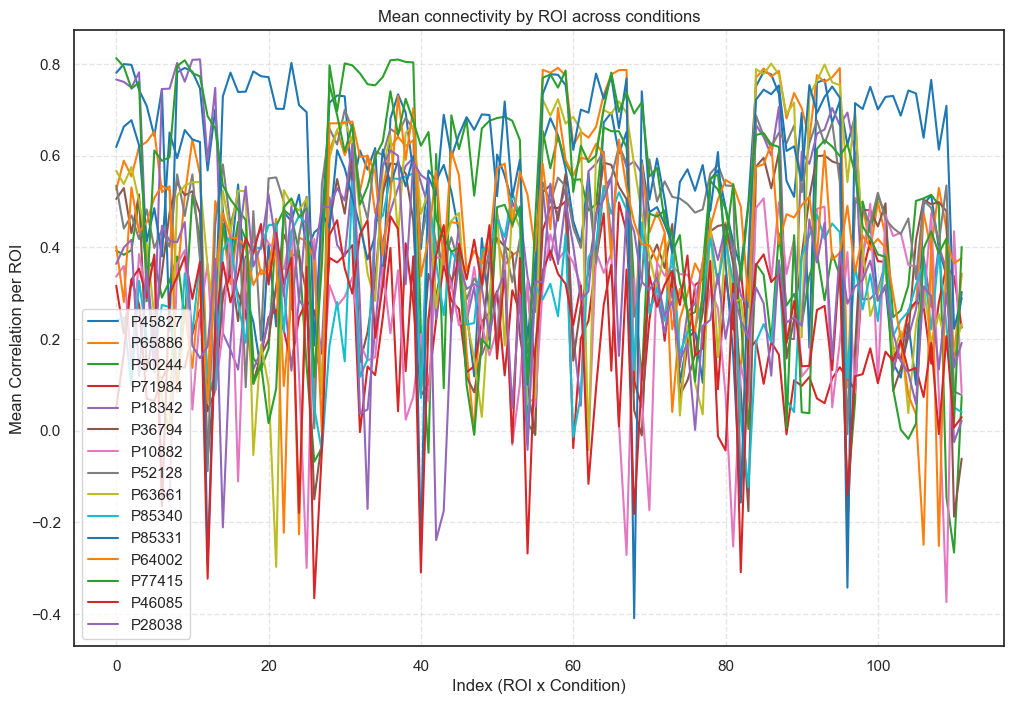

In [97]:
plot_roi_condition(all_matrices)

In [98]:
def fingerprint_stats(data, pid):
    """Calculates the statistics across multiple participants for a given task and oxy/deoxy
    :param data: dictionary with pid's to correlation matrices"""
    matrices = data[pid]
    rows = []
    #for pid, matrices in data.items():

    # add stats for each type of matrix
    for matrix in matrices:
        rows.append([matrix.values.mean(axis=0), matrix.values.std(axis=0), matrix.values.min()])

    # assign index as ROI and columns as stats
    df = pd.DataFrame(rows, index = ['Rest O2Hb', "Rest HHb", "0-Back O2Hb", "0-Back HHb", "1-Back O2Hb", "1-Back HHb", "2-Back O2Hb", "2-Back HHb"], columns=["Mean", "Standard Deviation", "Min"])

    return df

In [99]:
stats_data1 = fingerprint_stats(all_matrices, PID1)
#stats_data2 = fingerprint_stats(all_matrices, PID2)

stats_data1

,Mean,Standard Deviation,Min
Rest O2Hb,"[0.7809336618928997, 0.8000244867433884, 0.798...","[0.20341170463884892, 0.21015270810364242, 0.2...",0.003578
Rest HHb,"[0.48022323316379634, 0.36020629393501, 0.5373...","[0.2534385002339589, 0.264775891782229, 0.2601...",-0.417661
0-Back O2Hb,"[0.7155911852810911, 0.7315519680880926, 0.729...","[0.18860384197180238, 0.2159584468467864, 0.20...",0.005262
0-Back HHb,"[0.5450797014803571, 0.5800470526415195, 0.521...","[0.29846515128530837, 0.3278309693655188, 0.35...",-0.382712
1-Back O2Hb,"[0.6307915116200952, 0.6819655499935974, 0.644...","[0.23759901041803685, 0.23578350338554477, 0.2...",-0.191798
1-Back HHb,"[0.4767158971737917, 0.4879110508644709, 0.450...","[0.2870630289667821, 0.3621523099794423, 0.297...",-0.601468
2-Back O2Hb,"[0.7514915890255931, 0.7835710888626813, 0.777...","[0.23181052872292504, 0.2259707913531834, 0.21...",-0.147015
2-Back HHb,"[0.38725749768662066, 0.454979784111604, 0.283...","[0.31654099466882696, 0.35532226420197177, 0.3...",-0.637758


In [100]:
def fingerprint_similarity_pearson(matrix1, matrix2):
    """Calculates similarity between different correlation matrices between participants under the same condition
    :param matrix1: correlation matrix for participant1 for a given condition
    :param matrix2: correlation matrix for participant2 for the same condition"""
    fp1 = matrix1.values.flatten()
    fp2 = matrix2.values.flatten()

    # calculate correlation between fingerprints
    similarity = np.corrcoef(fp1, fp2)[0, 1]
    return similarity

In [101]:
def compute_similarity_matrix(matrix_dict, condition='oxy_rest'):
    """Compute pairwise similarity between all participants

    Note: This plot code was generated with Claude
    """
    # Map condition names to indices
    condition_map = {
        'oxy_rest': 0, 'deoxy_rest': 1,
        'oxy_0back': 2, 'deoxy_0back': 3,
        'oxy_1back': 4, 'deoxy_1back': 5,
        'oxy_2back': 6, 'deoxy_2back': 7
    }

    idx = condition_map[condition]
    pids = list(matrix_dict.keys())
    n_participants = len(pids)

    # Initialize similarity matrix
    similarity_matrix = np.zeros((n_participants, n_participants))

    for i, pid1 in enumerate(pids):
        for j, pid2 in enumerate(pids):
            matrix1 = matrix_dict[pid1][idx]
            matrix2 = matrix_dict[pid2][idx]

            similarity_matrix[i, j] = fingerprint_similarity_pearson(matrix1, matrix2)

    # Convert to DataFrame
    sim_df = pd.DataFrame(similarity_matrix,
                          index=[f'P{pid}' for pid in pids],
                          columns=[f'P{pid}' for pid in pids])

    return sim_df

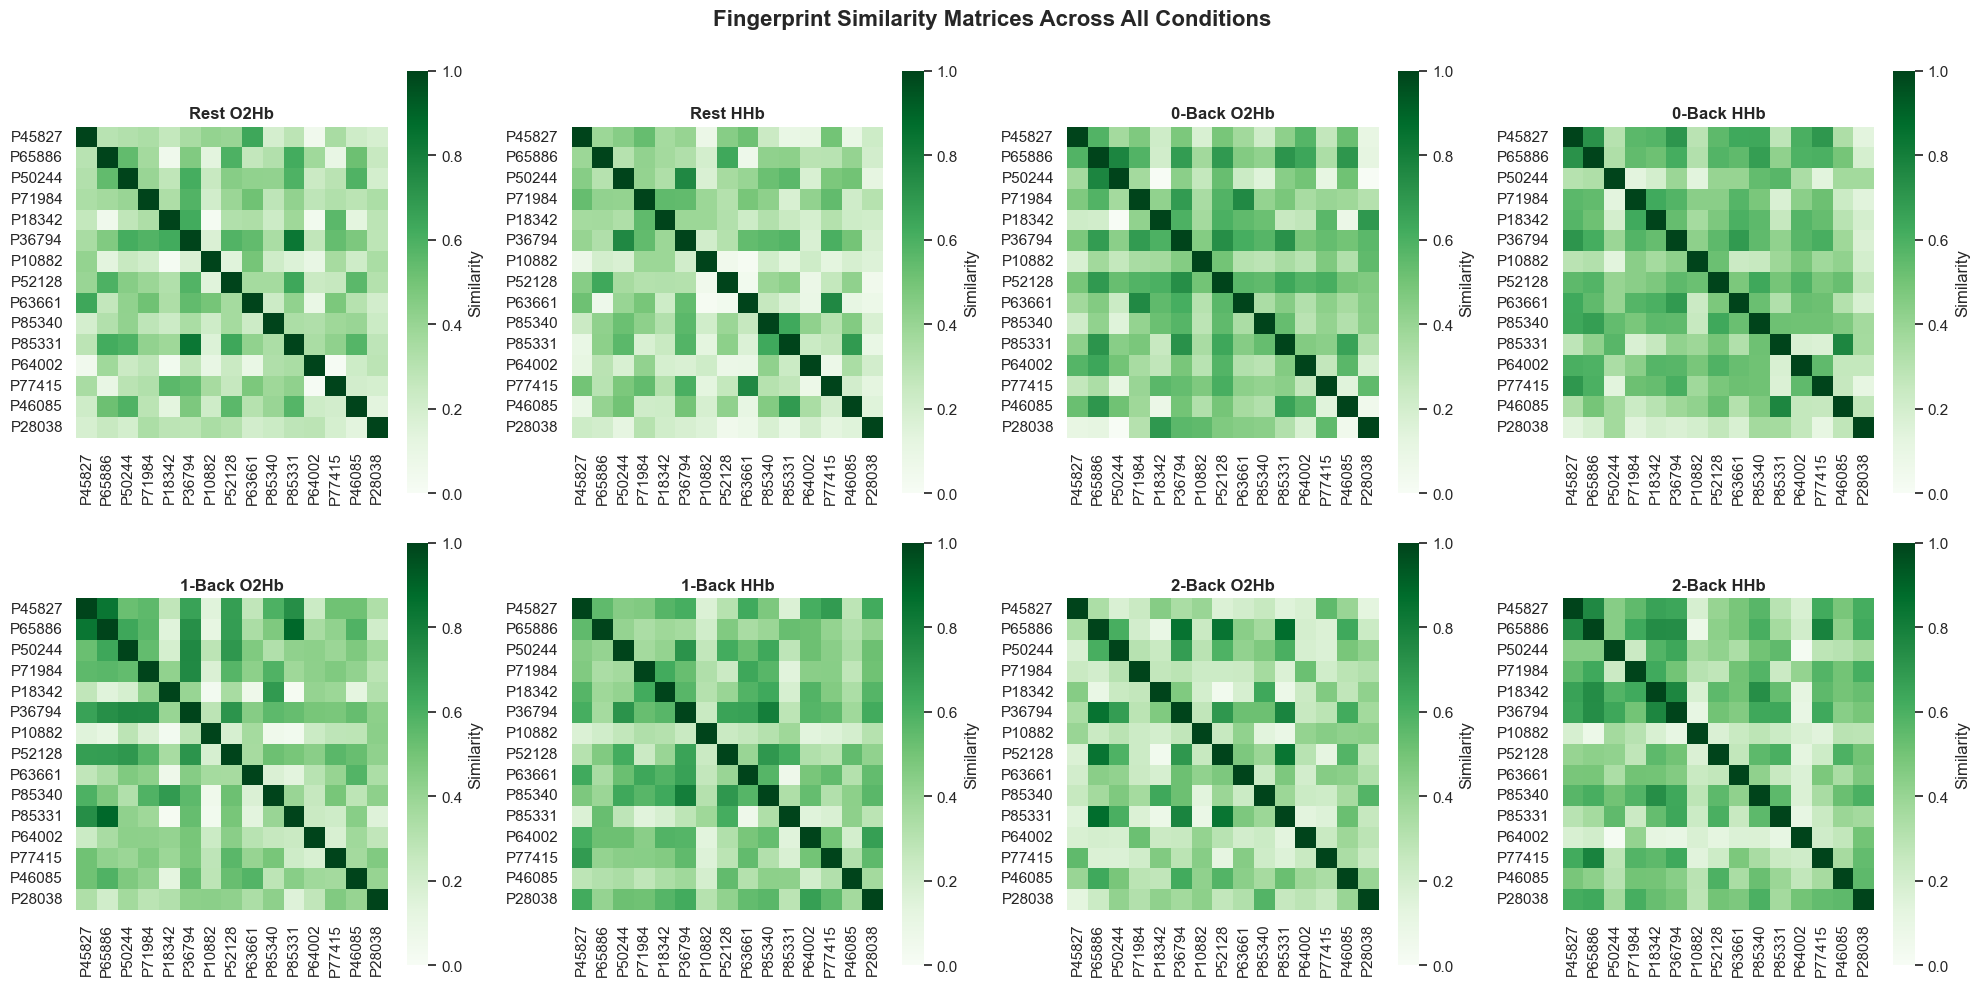

In [108]:
def plot_all_similarity_matrices(matrix_dict):
    """Plot similarity matrices for all conditions in one figure

    Note: this plot code was generated with Claude"""

    condition_map = {
        'oxy_rest': 0, 'deoxy_rest': 1,
        'oxy_0back': 2, 'deoxy_0back': 3,
        'oxy_1back': 4, 'deoxy_1back': 5,
        'oxy_2back': 6, 'deoxy_2back': 7
    }

    condition_names = {
        'oxy_rest': 'Rest O2Hb',
        'deoxy_rest': 'Rest HHb',
        'oxy_0back': '0-Back O2Hb',
        'deoxy_0back': '0-Back HHb',
        'oxy_1back': '1-Back O2Hb',
        'deoxy_1back': '1-Back HHb',
        'oxy_2back': '2-Back O2Hb',
        'deoxy_2back': '2-Back HHb'
    }

    fig, axes = plt.subplots(2, 4, figsize=(20, 10), facecolor='w')
    axes = axes.flatten()

    for idx, (condition_key, condition_idx) in enumerate(condition_map.items()):
        sim_matrix = compute_similarity_matrix(matrix_dict, condition=condition_key)

        sns.heatmap(sim_matrix,
                    ax=axes[idx],
                    annot=False,
                    fmt='.1f',  # Use .2f for less clutter
                    cmap="Greens",
                    vmin=0,
                    vmax=1,
                    square=True,
                    cbar_kws={'label': 'Similarity'})

        axes[idx].set_title(condition_names[condition_key], fontweight='bold')

    plt.suptitle('Fingerprint Similarity Matrices Across All Conditions',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('plots/fingerprint_similarity_matrices-all.png')
    plt.show()


    return fig

# Usage
fig = plot_all_similarity_matrices(all_matrices)

In [115]:
def plot_fingerprint_quality_summary(matrix_dict):
    """Bar chart showing discrimination quality per condition

    Note: this plot code base was generated with Claude and edited"""

    condition_map = {
        'Rest O2Hb': 'oxy_rest',
        'Rest HHb': 'deoxy_rest',
        '0-Back O2Hb': 'oxy_0back',
        '0-Back HHb': 'deoxy_0back',
        '1-Back O2Hb': 'oxy_1back',
        '1-Back HHb': 'deoxy_1back',
        '2-Back O2Hb': 'oxy_2back',
        '2-Back HHb': 'deoxy_2back'
    }

    results = []

    for label, condition in condition_map.items():
        sim_matrix = compute_similarity_matrix(matrix_dict, condition=condition)

        # Get off-diagonal (between-subject) similarities
        mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
        between_subj = sim_matrix.values[mask]

        results.append({
            'Condition': label,
            'Mean_Similarity': between_subj.mean(),
            'Std': between_subj.std()
        })

    df = pd.DataFrame(results)

    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = ['#d62728' if 'Rest' in x else '#2ca02c' if '2-Back' in x
              else '#ff7f0e' if '0-Back' in x else '#8ACE00' for x in df['Condition']]

    bars = ax.bar(df['Condition'], df['Mean_Similarity'],
                   color=colors, alpha=0.7, edgecolor='black')
    ax.errorbar(df['Condition'], df['Mean_Similarity'],
                yerr=df['Std'], fmt='none', color='black', capsize=5)

    # Add threshold line
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2,
               label='Target threshold (< 0.5 = good)')

    ax.set_xlabel('Condition', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Similarity Across Participants', fontsize=12, fontweight='bold')
    plt.savefig('plots/similarity_boxplots.png')
    plt.show()

    return df

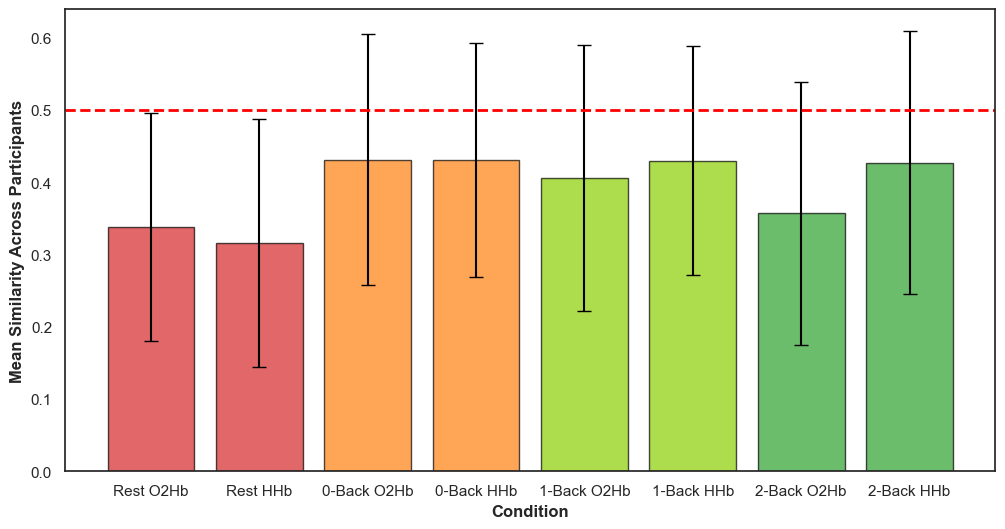

,Condition,Mean_Similarity,Std
0,Rest O2Hb,0.337729,0.157991
1,Rest HHb,0.315921,0.171707
2,0-Back O2Hb,0.431363,0.174166
3,0-Back HHb,0.430418,0.162062
4,1-Back O2Hb,0.406409,0.184079
5,1-Back HHb,0.429797,0.158656
6,2-Back O2Hb,0.357198,0.181968
7,2-Back HHb,0.427017,0.182069


In [117]:
all_stats = plot_fingerprint_quality_summary(all_matrices)
all_stats

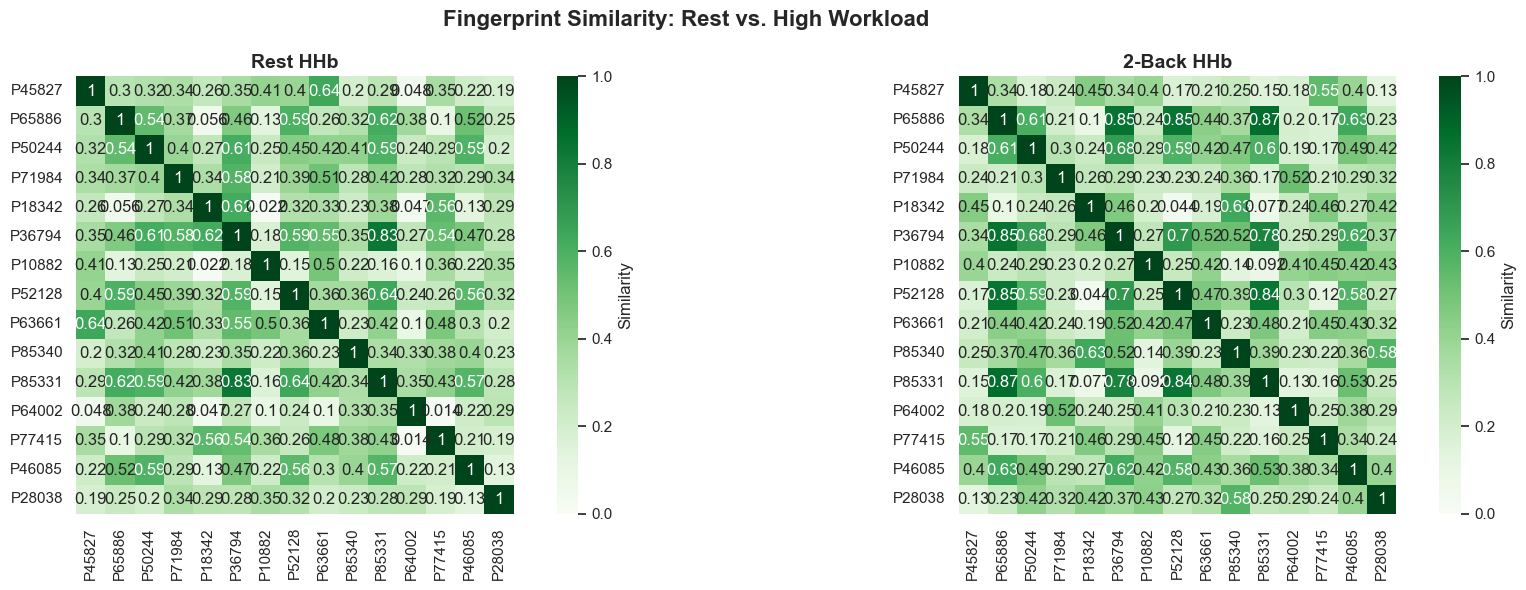

In [114]:
def plot_key_conditions(matrix_dict):
    """Show only the most informative conditions

    Note: This plot code base was generated with Claude and edited"""

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    conditions = [
        ('oxy_rest', 'Rest HHb'),
        ('oxy_2back', '2-Back HHb')
    ]

    for idx, (condition, title) in enumerate(conditions):
        sim_matrix = compute_similarity_matrix(matrix_dict, condition=condition)

        sns.heatmap(sim_matrix,
                    ax=axes[idx],
                    annot=True,
                    cmap="Greens",
                    vmin=0,
                    vmax=1,
                    square=True,
                    cbar_kws={'label': 'Similarity'})

        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')

    plt.suptitle('Fingerprint Similarity: Rest vs. High Workload',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/low_high_matrix.png')
    plt.show()

# Usage
plot_key_conditions(all_matrices)